In [220]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
from scipy.signal import butter, filtfilt, welch, spectrogram

# Data preprocessing, filtering, and segmentation
- We capture our EEG data as a pandas pickle object, from which we extract numpy arrays for both time stamps and eeg data.

In [120]:
with open('cached_EEG.pkl', 'rb') as f:
    eeg_df = pickle.load(f)

In [121]:
eeg_df.head(5)

,EEG,Max_Time
0,0.0,0.000
1,5987.1,1.953
2,5966.0,3.906
3,5950.1,5.859
4,5922.5,7.812


In [191]:
eeg_signal = eeg_df['EEG'].to_numpy()
time_stamps = eeg_df['Max_Time'].to_numpy()

- We preprocess the data to remove all other interferances (such as muscle twitches), by running a high pass filter to exclude all frequencies below 1Hz

In [192]:
SAMPLING_FS = 512
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

filtered_signal = highpass_filter(eeg_signal, 1, SAMPLING_FS)

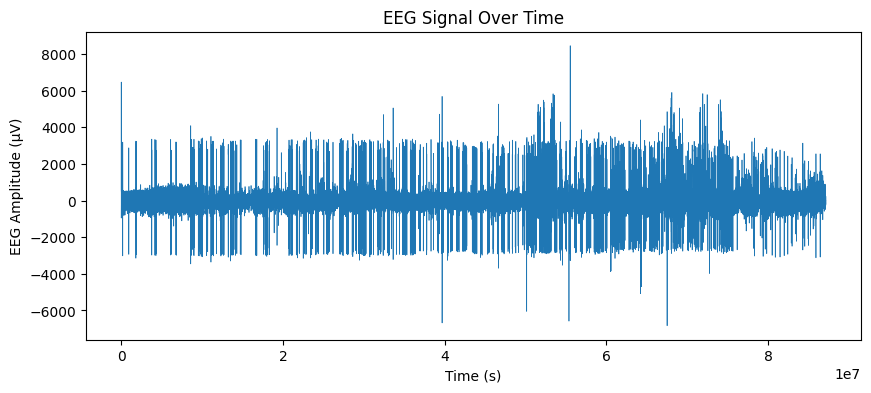

In [193]:
plt.figure(figsize=(10, 4))
plt.plot(time_stamps, filtered_signal, linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
plt.show()

- To make our data easier to process and analyze at smaller time-intervals (to narrow down the precise point in time that a seizure occurs), we segment the data into 5 minute intervals.

In [194]:
SEGMENTATION_LENGTH = 2560
NUM_SAMPLES = len(filtered_signal)
TRIMMED_LENGTH = NUM_SAMPLES % SEGMENTATION_LENGTH
NUMBER_OF_SEGMENTATIONS = NUM_SAMPLES // SEGMENTATION_LENGTH
trimmed_signal = filtered_signal[TRIMMED_LENGTH:]
trimmed_time_stamps = time_stamps[TRIMMED_LENGTH:]
np.shape(trimmed_signal)

(44620800,)

In [195]:
segmented_signal = trimmed_signal.reshape((NUMBER_OF_SEGMENTATIONS, SEGMENTATION_LENGTH))
segmented_time_stamps = trimmed_time_stamps.reshape((NUMBER_OF_SEGMENTATIONS, SEGMENTATION_LENGTH))
np.shape(segmented_signal)
np.shape(segmented_time_stamps)

(17430, 2560)

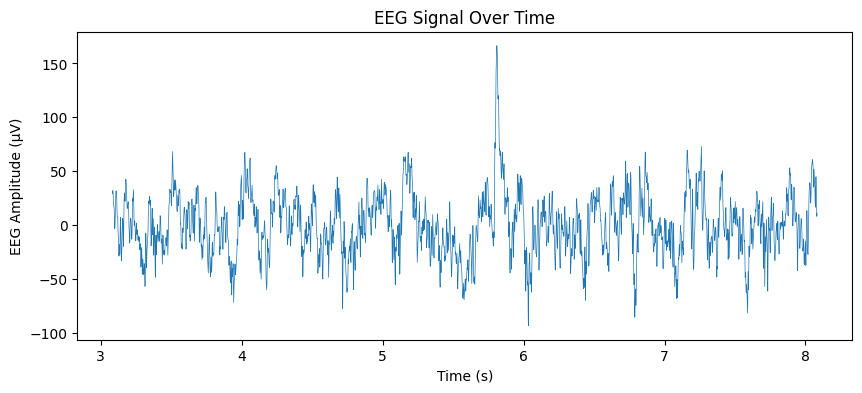

In [ ]:
# We plot an example of a segmented piece of data
plt.figure(figsize=(10, 4))
plt.plot(segmented_time_stamps[0] / 1000, segmented_signal[0], linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
##plt.show()

# Features Extraction for Learning Algorithm
- We employ signal processing techniques to extract several key features of our signal to be processed by some learning algorithm to categorize seizure events.
- There are three main types of features we may capture:
    - Time-domain features (e.g., amplitude, variance, energy)
    - Frequency-domain features (e.g., power spectral density on frequency bands using Fourier Transform)
    - Time-frequency features (e.g., wavelet transform for analyzing transient events)

In [214]:
SAMPLE_INDEX = 1000
TEST_SEGMENT = segmented_signal[SAMPLE_INDEX]
TEST_TIME_STAMPS = segmented_time_stamps[SAMPLE_INDEX]

## Time-domain features
- We have the following features to calculate per segmentation:  
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Mean</td>
        <td>Average amplitude of EEG segment</td>
    </tr>
    <tr>
        <td>Variance</td>
        <td>Measures EEG signal dispersion</td>
    </tr>
    <tr>
        <td>Standard Deviation</td>
        <td>Spread of EEG values</td>
    </tr>
    <tr>
        <td>Kurtosis</td>
        <td>Measures peak sharpness of EEG segment</td>
    </tr>
    <tr>
        <td>Skewness</td>
        <td>Asymmetry of signal distribution</td>
    </tr>
    <tr>
        <td>Energy</td>
        <td>Sum of squared amplitudes</td>
    </tr>
    <tr>
        <td>Root Mean Square</td>
        <td>Measures overall amplitude strength</td>
    </tr>
    <tr>
        <td>Entropy</td>
        <td>Measures randomness</td>
    </tr>
    <tr>
        <td>Zero-crossing Rate</td>
        <td>Measures oscillation of amplitude</td>
    </tr>
</table>


In [217]:
TEST_SEGMENT

array([-0.01959951, 11.02744994, 16.97316922, ..., -6.97164227,
       -2.89245926, -2.6115895 ])

In [216]:
def compute_time_domain_features(eeg_signal):
    features = {}
    
    # Basic Statistical Features
    features["Mean"] = np.mean(eeg_signal)
    features["Variance"] = np.var(eeg_signal)
    features["Standard Deviation"] = np.std(eeg_signal)
    features["Kurtosis"] = stats.kurtosis(eeg_signal)
    features["Skewness"] = stats.skew(eeg_signal)
    
    # Energy & Power Features
    features["Energy"] = np.sum(np.square(eeg_signal))
    features["RMS"] = np.sqrt(np.mean(np.square(eeg_signal)))
    
    # Entropy (Shannon Entropy)
    probability_distribution = np.histogram(eeg_signal, bins=10, density=True)[0]
    probability_distribution = probability_distribution[probability_distribution > 0]  # Avoid log(0)
    features["Entropy"] = -np.sum(probability_distribution * np.log2(probability_distribution))

    # ZCR (Zero Crossing Rate)
    zero_crossings = np.where(np.diff(np.sign(eeg_signal)))[0]
    features["Zero-Crossing Rate"] = len(zero_crossings) / len(eeg_signal)
    
    return features

time_features = compute_time_domain_features(TEST_SEGMENT)
print("Extracted Time-Domain Features:")
for key, value in time_features.items():
    print(f"{key}: {value:.4f}")

Extracted Time-Domain Features:
Mean: -0.0506
Variance: 1052.1889
Standard Deviation: 32.4375
Kurtosis: 2.1487
Skewness: -0.8300
Energy: 2693610.0238
RMS: 32.4375
Entropy: 0.2546
Zero-Crossing Rate: 0.0938


## Frequency-Domain Features
- We have the following frequency-domain features to capture for each segmentation
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Peak Frequency</td>
        <td>Frequency with the highest power</td>
    </tr>
    <tr>
        <td>Spectral Entropy</td>
        <td>Measures disorder in the power spectrum</td>
    </tr>
    <tr>
        <td>Mean Frequency</td>
        <td>Weighted average of frequency components</td>
    </tr>
    <tr>
        <td>Power in Frequency Bands</td>
        <td>Power in Delta, Theta, Alpha, Beta, and Gamma bands</td>
    </tr>
</table>

- This is the Welch PSD of our test eeg segment


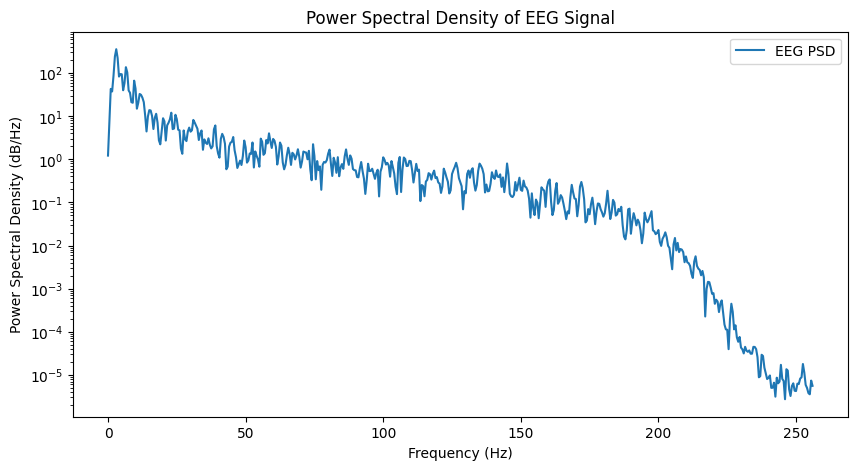

In [218]:
def compute_psd(data, fs):
    f, psd = welch(data, fs, nperseg=fs*2)
    return f, psd

f, psd_raw = compute_psd(TEST_SEGMENT, SAMPLING_FS)
plt.figure(figsize=(10,5))
plt.semilogy(f, psd_raw, label="EEG PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.title("Power Spectral Density of EEG Signal")
plt.legend()
plt.show()

- We now compute some of our frequency domain features:

In [219]:
def compute_frequency_features(eeg_signal, fs):
    features = {}

    # Compute Power Spectral Density (PSD) using Welch’s method
    f, psd = welch(eeg_signal, fs, nperseg=fs*2)

    # Peak Frequency (Highest Power)
    peak_freq = f[np.argmax(psd)]
    features["Peak Frequency"] = peak_freq

    # Mean Frequency (Weighted Average)
    mean_freq = np.sum(f * psd) / np.sum(psd)
    features["Mean Frequency"] = mean_freq

    # Spectral Entropy (Normalized Shannon Entropy of PSD)
    psd_norm = psd / np.sum(psd)  # Normalize PSD
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))  # Avoid log(0)
    features["Spectral Entropy"] = spectral_entropy

    return features

frequency_features = compute_frequency_features(TEST_SEGMENT, SAMPLING_FS)

# Print extracted features
print("Extracted Frequency-Domain Features:")
for key, value in frequency_features.items():
    print(f"{key}: {value:.4f}")

Extracted Frequency-Domain Features:
Peak Frequency: 3.0000
Mean Frequency: 13.4988
Spectral Entropy: 5.4779


### EEG Frequency Band Decomposition
- From what I have gathered, the following frequency bands correlate to different brain waves in rodents:
    - Delta (0.5–4 Hz) → Deep sleep, unconscious states
    - Theta (4–8 Hz) → Drowsiness, early seizure activity
    - Alpha (8–13 Hz) → Relaxed wakefulness
    - Beta (13–30 Hz) → Active thinking, alertness
    - Gamma (30–100 Hz) → High-frequency oscillations, seizure biomarkers.
- We can perform a bandpass filter on each frequency band and then analyze the power of each band using Welch's method.

In [197]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [200]:
delta_band = bandpass_filter(TEST_SEGMENT, 0.5, 4, 512)
theta_band = bandpass_filter(TEST_SEGMENT, 4, 8, 512)
alpha_band = bandpass_filter(TEST_SEGMENT, 8, 13, 512)
beta_band = bandpass_filter(TEST_SEGMENT, 13, 30, 512)
gamma_band = bandpass_filter(TEST_SEGMENT, 30, 100, 512)

frequency_bands = [delta_band, theta_band, alpha_band, beta_band, gamma_band]

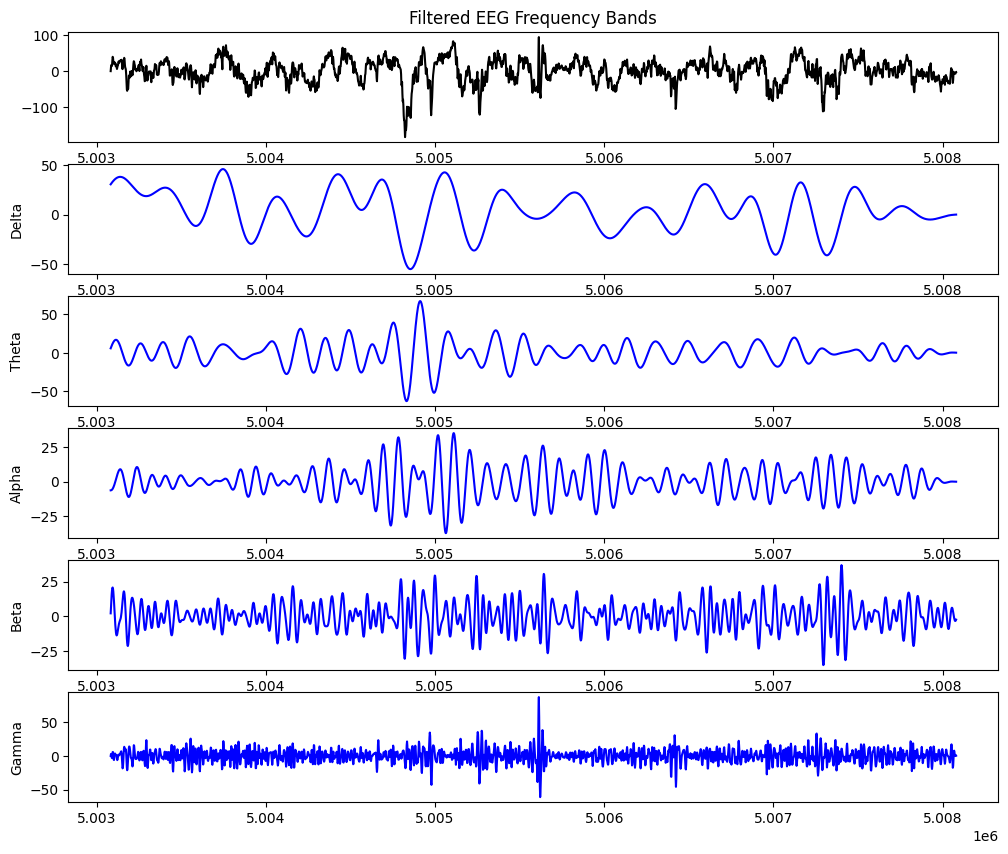

In [201]:
FREQUENCY_BAND_MAPPING = {
    0 : "Delta",
    1 : "Theta",
    2 : "Alpha",
    3 : "Beta",
    4 : "Gamma"
}


plt.figure(figsize=(12,10))
plt.subplot(6, 1, 1)
plt.plot(TEST_TIME_STAMPS, TEST_SEGMENT, label="Raw EEG", color='black')
plt.xlabel("Time (s)")
plt.title("Filtered EEG Frequency Bands")
for i in range(2, 7):
    plt.subplot(6, 1, i)
    plt.plot(TEST_TIME_STAMPS, frequency_bands[i-2], color='blue')
    plt.ylabel(FREQUENCY_BAND_MAPPING[i-2])


plt.show()

- Now we could compute the power of each frequency band and use that as a feature for whatever learning model that we create.

- Finally, computing the power of each frequency band:
    - We do this by taking the integral of the PSD over each specified frequency interval

In [210]:
def compute_band_power(psd, f, low, high):
    idx_band = np.logical_and(f >= low, f <= high)
    return np.trapz(psd[idx_band], f[idx_band])

delta_power = compute_band_power(psd_raw, f, 0.5, 4)
theta_power = compute_band_power(psd_raw, f, 4, 8)
alpha_power = compute_band_power(psd_raw, f, 8, 13)
beta_power = compute_band_power(psd_raw, f, 13, 30)
gamma_power = compute_band_power(psd_raw, f, 30, 100)

band_powers = {
    "Delta (0.5-4 Hz)": delta_power,
    "Theta (4-8 Hz)": theta_power,
    "Alpha (8-13 Hz)": alpha_power,
    "Beta (13-30 Hz)": beta_power,
    "Gamma (30-100 Hz)": gamma_power,
}

print("EEG Band Power:")
for band, power in band_powers.items():
    print(f"{band}: {power:.4f}")

EEG Band Power:
Delta (0.5-4 Hz): 515.6594
Theta (4-8 Hz): 312.9013
Alpha (8-13 Hz): 152.9910
Beta (13-30 Hz): 116.0177
Gamma (30-100 Hz): 112.2790


## Time-Frequency Features
- I don't really understand how some of this more advanced signal processing works, but I've narrowed down my search for features into three key Time-Frequency Features
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Short-Time Fourier Transform</td>
        <td>Tracks frequency variations over time</td>
    </tr>
    <tr>
        <td>Wavelet Transform</td>
        <td>Captures time-localized frequency patterns</td>
    </tr>
    <tr>
        <td>Hilbert Transform</td>
        <td>Spread of EEG values</td>
    </tr>
</table>

- I will be excluding hilbert transform for now, as I do not fully understand what it really does for the signal.

## Short-Time Fourier Transform

- The following is some code I've copied from my EECS16A lab on how to perform stft on a short clip of data. Nothing too exciting happend in the data we extracted.

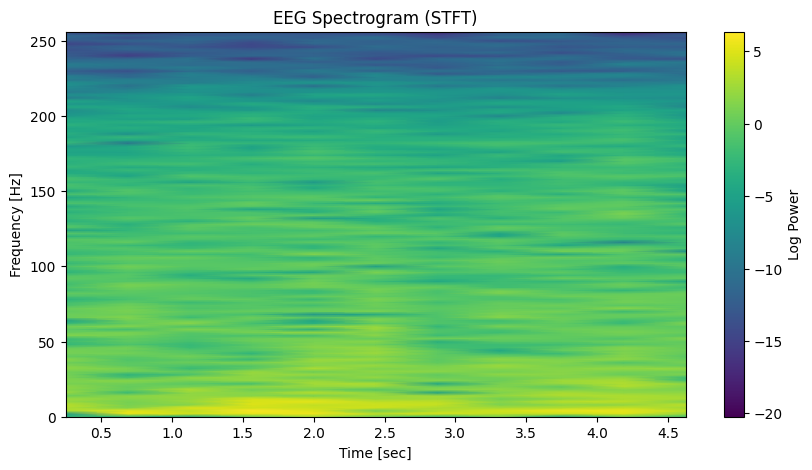

In [221]:
def compute_stft(eeg_signal, fs):
    f, t, Sxx = spectrogram(eeg_signal, fs, nperseg=fs//2)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("EEG Spectrogram (STFT)")
    plt.colorbar(label="Log Power")
    plt.show()
    
    return f, t, Sxx

f, t, Sxx = compute_stft(TEST_SEGMENT, SAMPLING_FS)

- For STFT, we may extract the following data:
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Spectral Centroid</td>
        <td>Weighted mean of frequencies</td>
    </tr>
    <tr>
        <td>Spectral Bandwidth</td>
        <td>Spread of frequencies around the centroid</td>
    </tr>
    <tr>
        <td>Spectral Entropy</td>
        <td>Disorder in the spectrogram</td>
    </tr>
    <tr>
        <td>Spectral Flatness</td>
        <td>Tonality/Noisyness of the signal</td>
    </tr>
    <tr>
        <td>Spectrogram Energy</td>
        <td>Total energy in time-frequency domain</td>
    </tr>
</table>

In [233]:
import numpy as np
import scipy.signal as signal
import scipy.stats as stats

def extract_stft_features(eeg_signal, fs):
    f, t, Sxx = signal.spectrogram(eeg_signal, fs, nperseg=fs//2)

    # Normalize spectrogram to avoid numerical issues
    Sxx = np.abs(Sxx) + 1e-10  # Avoid log(0) issues

    features = {}

    # Spectral Centroid (Weighted mean of frequencies)
    spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
    features["Spectral_Centroid_Mean"] = np.mean(spectral_centroid)
    features["Spectral_Centroid_Std"] = np.std(spectral_centroid)

    # Spectral Bandwidth (Variance around centroid)
    spectral_bandwidth = np.sqrt(np.sum(((f[:, None] - spectral_centroid[None, :])**2) * Sxx, axis=0) / np.sum(Sxx, axis=0))
    features["Spectral_Bandwidth_Mean"] = np.mean(spectral_bandwidth)
    features["Spectral_Bandwidth_Std"] = np.std(spectral_bandwidth)

    # Spectral Entropy (Shannon entropy over time)
    Sxx_norm = Sxx / np.sum(Sxx, axis=0)  # Normalize
    spectral_entropy = -np.sum(Sxx_norm * np.log2(Sxx_norm + 1e-10), axis=0)
    features["Spectral_Entropy_Mean"] = np.mean(spectral_entropy)
    features["Spectral_Entropy_Std"] = np.std(spectral_entropy)

    # Spectral Flatness (Ratio of geometric mean to arithmetic mean)
    spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
    features["Spectral_Flatness_Mean"] = np.mean(spectral_flatness)
    features["Spectral_Flatness_Std"] = np.std(spectral_flatness)

    # Total Energy in Spectrogram
    features["Spectrogram_Total_Energy"] = np.sum(Sxx)

    return features

stft_features = extract_stft_features(TEST_SEGMENT, SAMPLING_FS)

print("Extracted STFT-Based Features:")
for key, value in stft_features.items():
    print(f"{key}: {value:.4f}")


Extracted STFT-Based Features:
Spectral_Centroid_Mean: 17.0345
Spectral_Centroid_Std: 5.5566
Spectral_Bandwidth_Mean: 25.7812
Spectral_Bandwidth_Std: 4.3373
Spectral_Entropy_Mean: 3.6076
Spectral_Entropy_Std: 0.6556
Spectral_Flatness_Mean: 0.0181
Spectral_Flatness_Std: 0.0074
Spectrogram_Total_Energy: 5892.1755


## DWT Decomposition
- I have found two Wavelet decomposition methods, a continuous wavelet transform that uses morlet wavlets, and a discrete wavelet transform that uses daubauchies wavelets.
    - A research into the two options reveals that the CWT is more accurate, but a lot more computationally intensive than a DWT approach, which I believe should be sufficient for our analysis.
- This is the CWT approach:

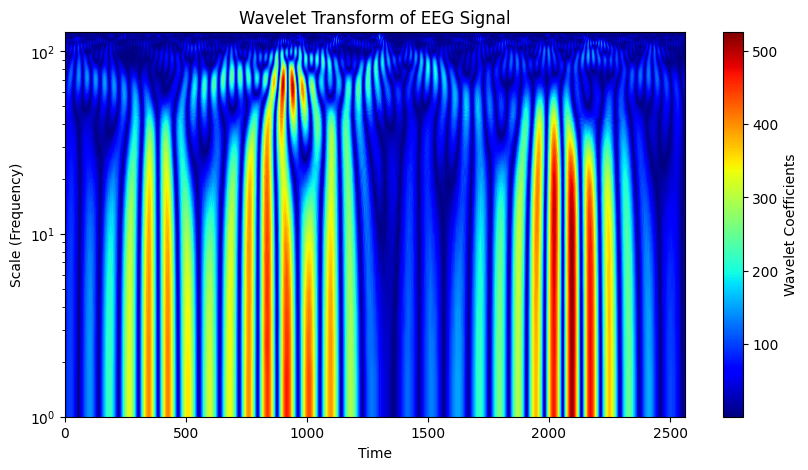

In [223]:
import pywt

def compute_CWT_transform(eeg_signal, wavelet='morl'):
    scales = np.arange(1, 128)  # Define scales for wavelet transform
    coefs, frequencies = pywt.cwt(eeg_signal, scales, wavelet)

    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coefs), aspect='auto', cmap='jet', extent=[0, len(eeg_signal), 1, 128])
    plt.yscale("log")
    plt.colorbar(label="Wavelet Coefficients")
    plt.xlabel("Time")
    plt.ylabel("Scale (Frequency)")
    plt.title("Wavelet Transform of EEG Signal")
    plt.show()
    
    return coefs, frequencies

# Example usage:
coefs, frequencies = compute_CWT_transform(TEST_SEGMENT)


- This is the DWT approach

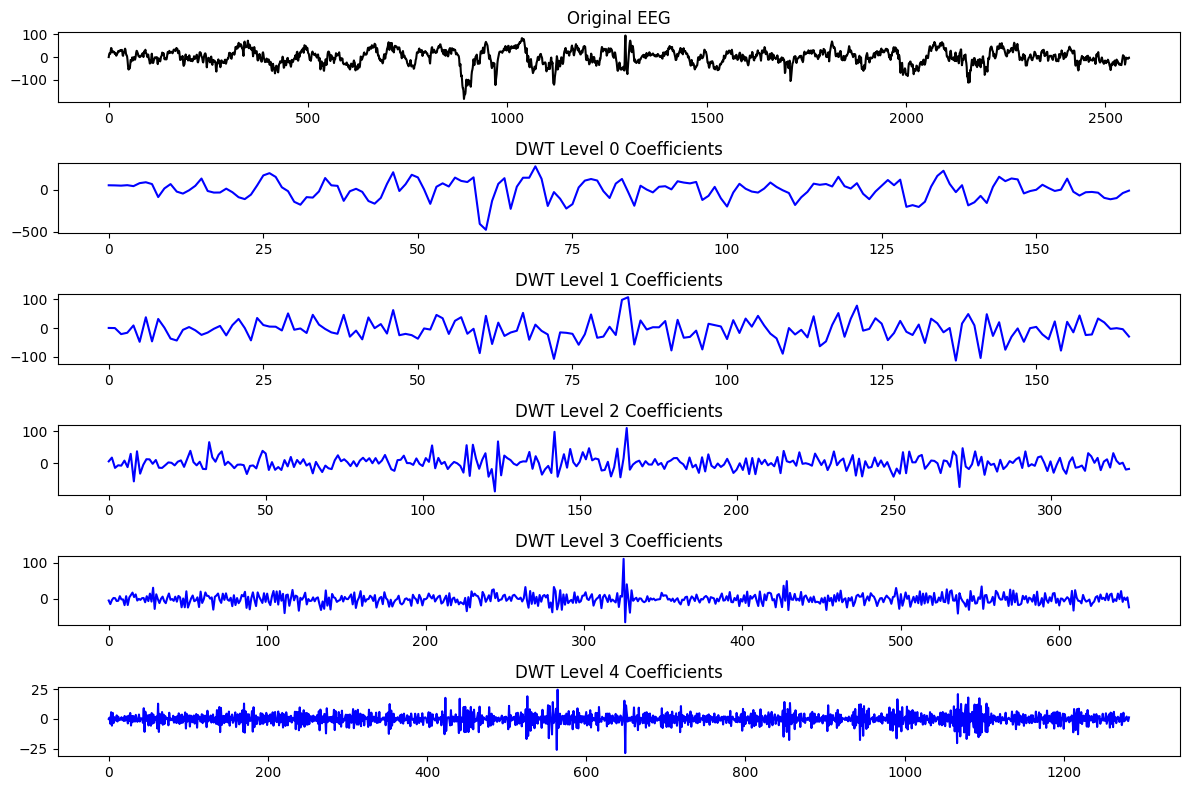

In [231]:
def compute_dwt(eeg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

    # Plot Approximation and Detail Coefficients
    plt.figure(figsize=(12, 8))
    plt.subplot(len(coeffs)+1, 1, 1)
    plt.plot(eeg_signal, color='black')
    plt.title("Original EEG")
    for i, coef in enumerate(coeffs):
        plt.subplot(len(coeffs)+1, 1, i+2)
        plt.plot(coef, color='blue')
        plt.title(f"DWT Level {i} Coefficients")
    plt.tight_layout()
    plt.show()

    return coeffs

# Example usage:
dwt_coeffs = compute_dwt(TEST_SEGMENT)

- Now we may try to extract features from the DWT approach. We will be focusing on basic statistical features, energy, as well as entropy.
    - I believe that high wavelet energy (particularly in DWT level 4 and level 3, which are D1 and D2 coefficients respectively), may correlate to seizure activity.
    - I also believe that increased Wavelet Entropy may indicate the EEG data getting more "choatic" during seizures.

In [232]:
def extract_wavelet_features(eeg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    
    features = {}
    
    for i, coef in enumerate(coeffs):
        # Statistical features
        features[f"Wavelet_Mean_L{i}"] = np.mean(coef)
        features[f"Wavelet_Variance_L{i}"] = np.var(coef)
        features[f"Wavelet_Skewness_L{i}"] = stats.skew(coef)
        features[f"Wavelet_Kurtosis_L{i}"] = stats.kurtosis(coef)
        
        # Energy of wavelet coefficients
        features[f"Wavelet_Energy_L{i}"] = np.sum(np.square(coef))
        
        # Entropy of wavelet coefficients
        coef_prob = np.abs(coef) / np.sum(np.abs(coef))  # Normalize
        features[f"Wavelet_Entropy_L{i}"] = -np.sum(coef_prob * np.log2(coef_prob + 1e-10))  # Shannon Entropy
    
    return features

# Example usage:
wavelet_features = extract_wavelet_features(TEST_SEGMENT)
print("Extracted Wavelet-Based Features:")
for key, value in wavelet_features.items():
    print(f"{key}: {value:.4f}")

Extracted Wavelet-Based Features:
Wavelet_Mean_L0: 1.3648
Wavelet_Variance_L0: 12991.5851
Wavelet_Skewness_L0: -0.7737
Wavelet_Kurtosis_L0: 1.6357
Wavelet_Energy_L0: 2156912.3363
Wavelet_Entropy_L0: 6.9391
Wavelet_Mean_L1: -5.3332
Wavelet_Variance_L1: 1312.0379
Wavelet_Skewness_L1: -0.1378
Wavelet_Kurtosis_L1: 0.8527
Wavelet_Energy_L1: 222519.8318
Wavelet_Entropy_L1: 6.8782
Wavelet_Mean_L2: 0.4159
Wavelet_Variance_L2: 512.8383
Wavelet_Skewness_L2: 0.4934
Wavelet_Kurtosis_L2: 3.0450
Wavelet_Energy_L2: 167241.6652
Wavelet_Entropy_L2: 7.8308
Wavelet_Mean_L3: -0.4697
Wavelet_Variance_L3: 198.0039
Wavelet_Skewness_L3: 0.5573
Wavelet_Kurtosis_L3: 6.4577
Wavelet_Energy_L3: 127854.8180
Wavelet_Entropy_L3: 8.8445
Wavelet_Mean_L4: 0.0001
Wavelet_Variance_L4: 27.8711
Wavelet_Skewness_L4: -0.1601
Wavelet_Kurtosis_L4: 2.2614
Wavelet_Energy_L4: 35758.6658
Wavelet_Entropy_L4: 9.8371
